In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from copy import deepcopy

import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as t

# from torchsummary import summary

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.plotters import Plotter
from src.utils import *
from src.costs import InnerGW_opt, InnerGW_const
from src.models.resnet import resnet14_d
from src.train import train


tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport",
                           entity="_devourer_")

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    torch.cuda.set_device(2)

In [4]:
n_components = 10
features, classes = load_mnist("../data/",
                               transform=t.Compose([t.Pad(2), t.ToTensor()]))
source = TensorDatasetDistribution(features, classes, device=DEVICE)

locs = 2 * uniform_circle(n_components)
scales = .2 * torch.ones_like(locs)
target = GaussianMixture(locs, scales, device=DEVICE)

p, q = source.event_shape.numel(), target.event_shape.numel()

U, s, V = torch.pca_lowrank(features.flatten(1), q)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [5]:
n_neurons = 128

mover = resnet14_d(source.event_shape, q).to(DEVICE)

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, 1), nn.Tanh()
).to(DEVICE)

In [11]:
def copy_models(*models):
    return [deepcopy(model) for model in models]

In [15]:
def run_experiment(source, target, mover, critic, cost, n_iter, *,
                   logger=None, **kwargs):
    if logger: logger.start()
    try:
        train(source, target, mover, critic, cost,
              n_iter=n_iter,
              logger=logger,
              **kwargs)
    except KeyboardInterrupt:
        pass
    finally:
        if logger: logger.finish()

wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


Output()

  0%|          | 0/4000 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/plotly/matplotlylib/renderer.py:574: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/opt/anaconda3/lib/python3.8/site-packages/plotly/matplotlylib/renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



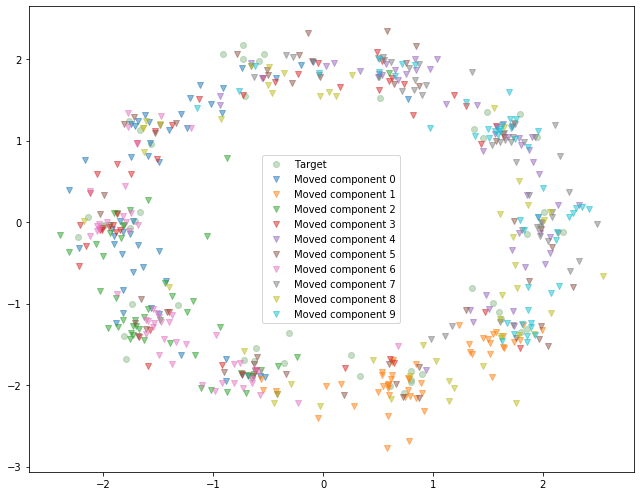

cost,▁▁▄▄▄█▃▅▃▄▄▂▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▆█▃█▅▆▆▄▆▃▅▃▄▂▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
cost,0.01293
loss,0.01104


In [7]:
run_experiment(
    source, target, *copy_models(mover, critic)
    n_iter=4000,
    n_samples=1024,
    cost=InnerGW_opt(p, q,
        optimizer_params=dict(lr=2e-5, weight_decay=1e-10),
        n_iter=2,
        device=DEVICE
    ),
    # cost=InnerGW_const(V.to(DEVICE)),
    plotter=Plotter(plot_interval=100,
                    plot_target=False,
                    plot_critic=False),
    logger=wandb_logger,
    n_iter_mover=2,
    optimizer_params=dict(lr=2e-5, weight_decay=1e-10),
)

Output()

  0%|          | 0/4000 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/plotly/matplotlylib/renderer.py:574: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/opt/anaconda3/lib/python3.8/site-packages/plotly/matplotlylib/renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



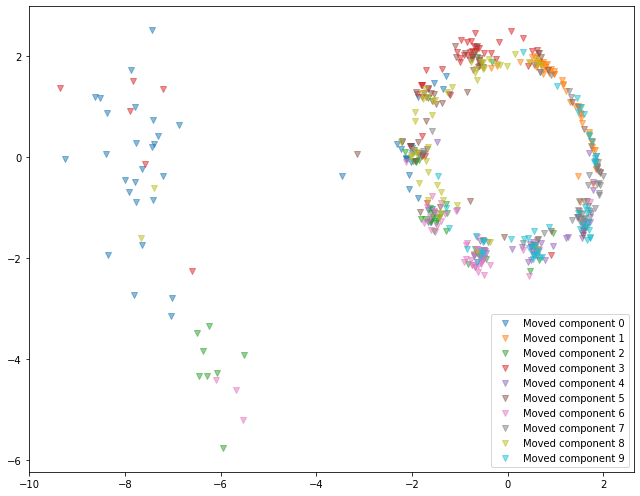

cost,▁▁▄▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇▇▇█▇▇▇▇███▇▇▇
loss,▁▃▆▇▆▇▇▇▇█▇▇▇█▇█▇██▇▇▇▇▇▇▇█▇██▇▇▇▇██▇▇▇▇
cost,0.34527
loss,0.49445


In [17]:
run_experiment(
    source, target, *copy_models(mover, critic),
    n_iter=4000,
    n_samples=1024,
    cost=InnerGW_const(V.to(DEVICE)),
    plotter=Plotter(plot_interval=100,
                    plot_target=False,
                    plot_critic=False),
    logger=wandb_logger,
    n_iter_mover=2,
    optimizer_params=dict(lr=2e-5, weight_decay=1e-10),
)